In [58]:

import pandas as pd
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')


def crosstab_with_percentages(rows, columns, x_order=None, y_order=None, table=False, heatmap=False):
    # Create the crosstab with absolutes
    cols = [c.astype(str) for c in columns]
    rows = [r.astype(str) for r in rows]

    xabs = pd.crosstab(rows, cols).fillna(0)
    xperc = pd.crosstab(rows, cols, normalize='columns').fillna(0)

    if x_order:
        xabs = xabs.reindex(x_order, axis=1)
        xperc = xperc.reindex(x_order, axis=1)

    if y_order:
        xabs = xabs.reindex(y_order)
        xperc = xperc.reindex(y_order)

    combined_data = {}

    for (adx, rabs), (pdx, rperc) in zip(xabs.iterrows(), xperc.iterrows()):

        row_data = {}
        row_total = 0

        for col in xabs.columns:
            row_data[col] = f"{rabs[col]} ({rperc[col]:.1%})"
            row_total += rabs[col]

        row_data['Total'] = f'{row_total} ({row_total / xabs.sum().sum():.1%})'
        combined_data[adx] = row_data

    row_data = {}
    row_total = 0
    for col in xabs.columns:
        row_data[col] = f'{sum(xabs[col])}'
        row_total += xabs[col].sum()

    row_data['Total'] = row_total
    combined_data['Total'] = row_data

    if table:
        display(pd.DataFrame.from_dict(combined_data).T)
        
    
    if heatmap:
        sns.heatmap(xperc, annot=True, fmt=".1%", cmap='Blues')
        plt.show()

    return xperc, pd.DataFrame.from_dict(combined_data)

workspace_path = Path(os.getcwd()).parent.parent

# Load data

In [59]:
person_data = pd.read_csv(f'{workspace_path}/data/summit/data/person_data.csv', low_memory=False)
nodule_data = pd.read_csv(f'{workspace_path}/data/summit/data/nodule_data.csv')

# Cluster analysis split by Gender

In [60]:

categorical_dict = {
    'radiology_report_nodule_spiculation' : 'spiculation',
    'radiology_report_nodule_site' : 'site',
    'radiology_report_nodule_type' : 'type',
    'radiology_report_management_plan' : 'management_plan'
}

numerical_dict = {
    'radiology_report_nodule_diameter_mm' : 'diameter'
}

Histogram comparison for radiology_report_nodule_diameter_mm for Nodule Diameter
Correlation between radiology_report_nodule_diameter_mm and nodule diameter for Nodule Diameter is 0.6808291296914745


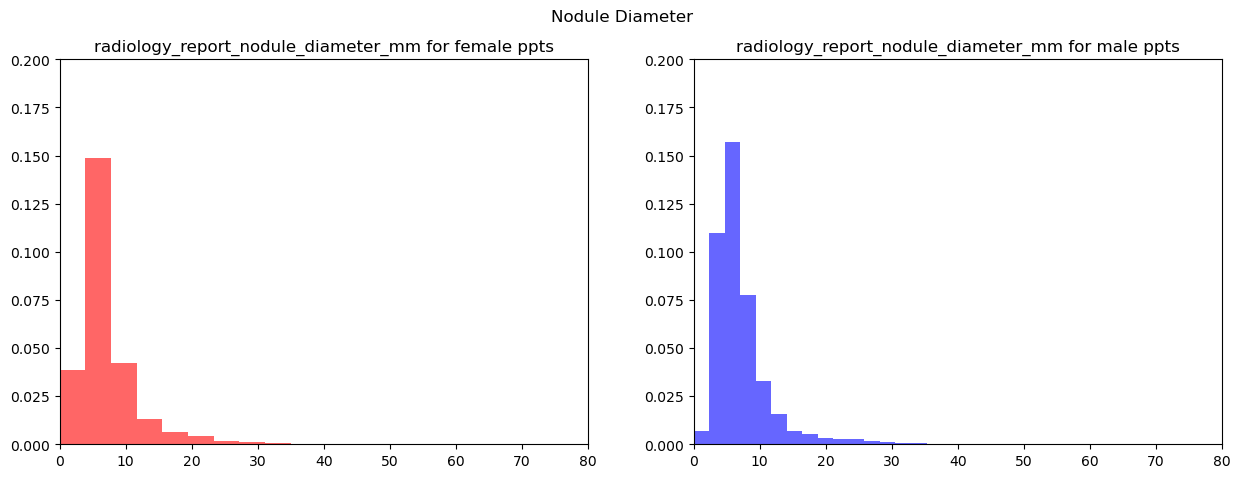

array([-0.00181781,  0.00181781])

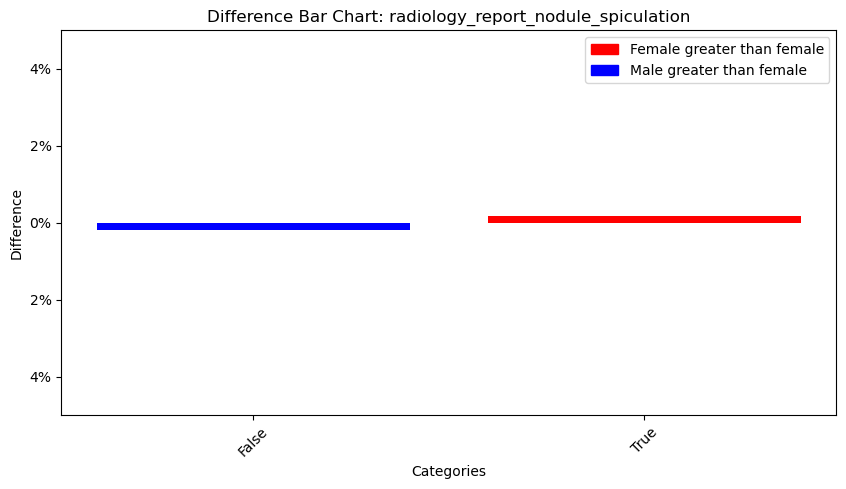

array([-0.01330566,  0.00035607, -0.00345224,  0.00175604, -0.00485036,
        0.01949616])

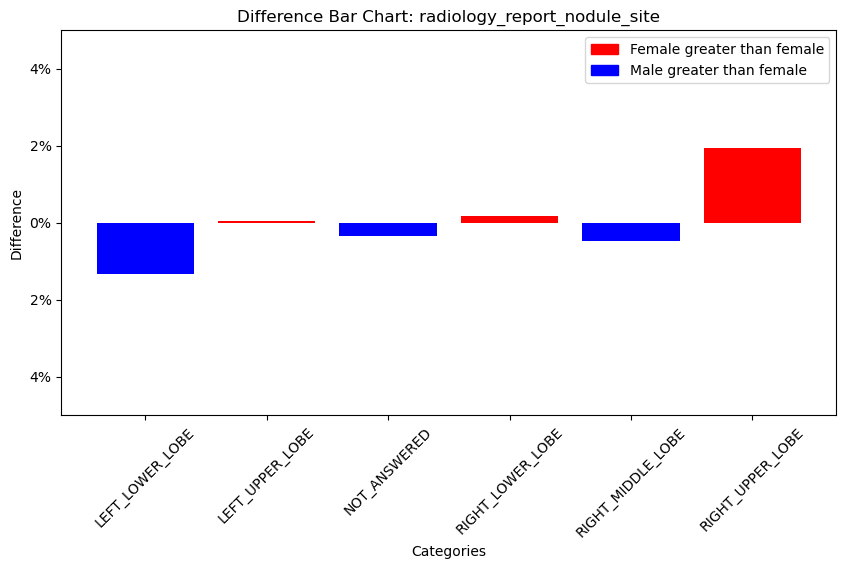

array([ 0.01158533,  0.00168915,  0.02805637,  0.01062198, -0.04070795,
       -0.01124487])

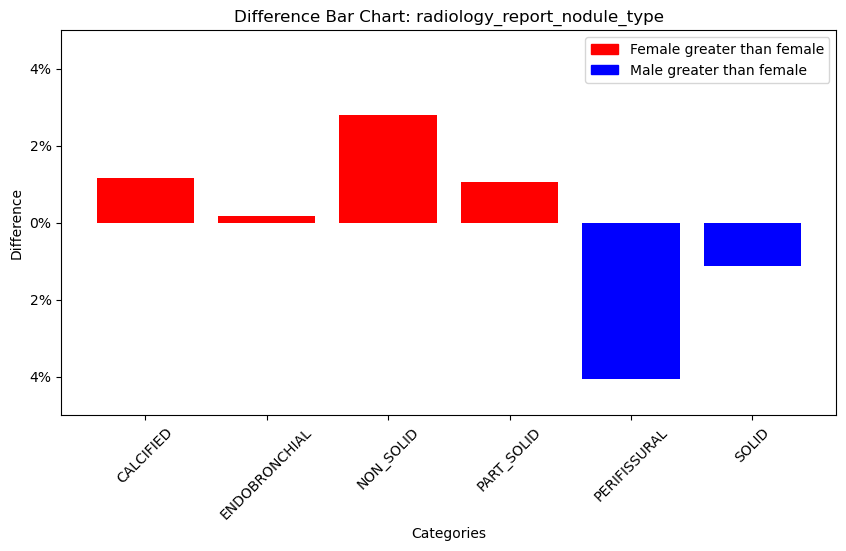

array([-0.00520616,  0.02504769, -0.02724902,  0.0074075 ])

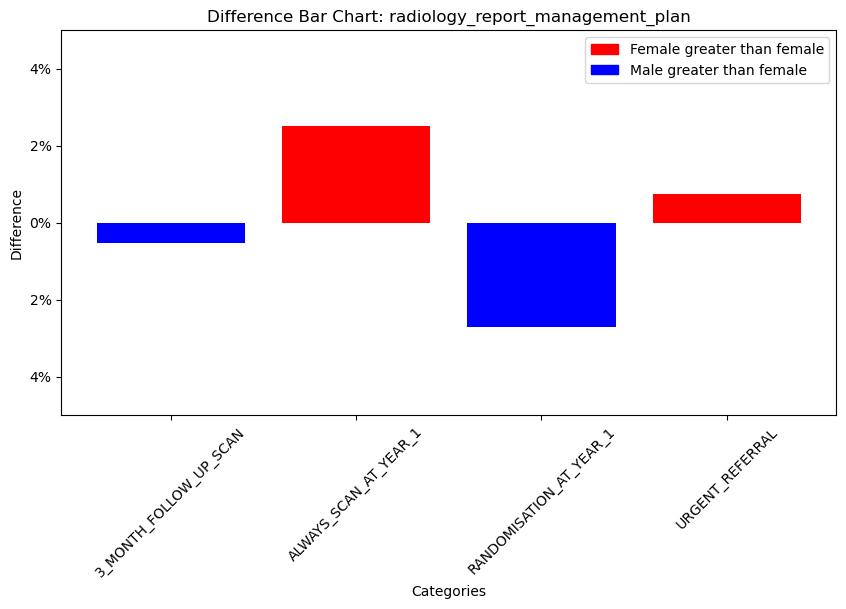

In [62]:
# Is Nodule Size the key driver ... compare histograms
import numpy as np
import cv2
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter

data_male = nodule_data[nodule_data['participant_details_gender'] == 'MALE']
data_female = nodule_data[nodule_data['participant_details_gender'] == 'FEMALE']

def hist_comparison(data1, data2, title, variable):

    hist1, bins1 = np.histogram(data1[variable], bins=20, density=True)
    hist2, bins2 = np.histogram(data2[variable], bins=20, density=True)

    hist1 = cv2.normalize(hist1, hist1).astype(np.float32)
    hist2 = cv2.normalize(hist2, hist2).astype(np.float32)

    print(f'Histogram comparison for {variable} for {title}')
    print(f'Correlation between {variable} and nodule diameter for {title} is {cv2.compareHist(hist1, hist2, cv2.HISTCMP_CORREL)}')

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].hist(data1[variable], bins=20, density=True, alpha=0.6, color='red')
    ax[0].set_title(f'{variable} for female ppts')
    ax[0].set_xlim(0, 80)
    ax[0].set_ylim(0, 0.2)


    ax[1].hist(data2[variable], bins=20, density=True, alpha=0.6, color='blue')
    ax[1].set_title(f'{variable} for male ppts')
    ax[1].set_xlim(0, 80)
    ax[1].set_ylim(0, 0.2)

    fig.suptitle(title)
    plt.show()

def differences_bar_chart(data1, data2, variable, title):

    values1 = data1[variable].value_counts().sort_index()/len(data1)
    values2 = data2[variable].value_counts().sort_index()/len(data2)

    cats = [str(i) for i in values1.index]

    # Calculate differences
    differences = np.array(values1) - np.array(values2)

    display(differences)

    # Create the bar chart
    fig, ax = plt.subplots(figsize=(10, 5))
    bars = ax.bar(cats, differences, color=['blue' if value < 0 else 'red' for value in differences])


    # Add labels and title
    ax.set_xticklabels(cats, rotation=45)
    ax.set_ylim(-0.05, 0.05)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Difference')
    ax.set_title(f'Difference Bar Chart: {variable}')
    # Function to format y-tick labels as percentages with sign
    def percentage_with_sign(x, pos):
        return f'{np.abs(x)*100:.0f}%'

    # Apply the formatter to the y-axis
    ax.yaxis.set_major_formatter(FuncFormatter(percentage_with_sign))


    positive_patch = Patch(color='red', label='Female greater than female')
    negative_patch = Patch(color='blue', label='Male greater than female')
    ax.legend(handles=[positive_patch, negative_patch])

    # Show the plot
    plt.show()


hist_comparison(data_female, data_male, 'Nodule Diameter', 'radiology_report_nodule_diameter_mm')

for key, value in categorical_dict.items():
    differences_bar_chart(data_female, data_male, key, value)
